In [1]:
import torch
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import plotnine as gg
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
import seaborn as sns
import tree
from data import rosetta_data_loader
import mdtraj as md

import sys
import argparse
import re
import logging

import pandas as pd
pd.set_option('display.max_colwidth', None)

from omegaconf import DictConfig, OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')
plt.rcParams.update({'font.size': 14})

INFO: Using numpy backend


In [26]:
all_csvs = []
# results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01'
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100'
print(f'Reading samples from {results_dir}')

def process_path(x):
    length_path = os.path.join(*x.split('/')[-5:])
    return os.path.join(results_dir, length_path)

for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    for sample_name in os.listdir(length_dir):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
        sample_id = int(sample_name.split('_')[1])
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            length = int(sample_length.split('_')[1])
            design_csv['length'] = length
            design_csv['sequence_id'] = design_csv['sample_path'].apply(lambda x: int(os.path.basename(x).replace('.pdb', '').split('_')[1]))
            design_csv['esmf_path'] = design_csv['sample_path'].apply(process_path)
            del design_csv['sample_path']
            design_csv['sample_id'] = sample_id
            design_csv['backbone_path'] = os.path.join(results_dir, f'length_{length}', f'sample_{sample_id}', 'sde_1.pdb')
            all_csvs.append(design_csv)
self_conditioned_df = pd.concat(all_csvs)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100


# Process results

In [27]:
length_categories = [
    '100-200', '200-300', '300-400', '400-500'
]
buckets = np.arange(200, 501, 100)
buckets[-1] += 1

def df_process(raw_df, length_cutoff=True):
    # Process sample path
    df = raw_df.copy()
    if length_cutoff:
        df = df[df.length >= 100]
    # Separate based on whether MPNNed
    df['header'] = df['header'].fillna('')
    df = df[df['header'].map(lambda x: 'sde_1' not in x)]
    return df

def sc_filter(raw_df, metric):
    # Pick best self-consistency sample
    if metric == 'rmsd':
        df = raw_df.sort_values('rmsd', ascending=True)
    elif metric == 'tm':
        df = raw_df.sort_values('tm_score', ascending=False)
    else:
        raise ValueError(f'Unrecognized metric: {metric}')
    df = df.groupby(['length', 'sample_id']).first().reset_index()

    # Separate into different length groups
    df['length_group'] = df.length.map(lambda x: length_categories[np.sum(x > buckets).item()])
    df['length_group'] = pd.Categorical(df['length_group'], ordered=True, categories=length_categories)

    # Calculate how designable
    cutoff = 0.5
    if metric == 'rmsd':
        df['designable'] = df.rmsd.map(lambda x: x < 2.0)
    elif metric == 'tm':
        df['designable'] = df.tm_score.map(lambda x: x > 0.5)
    designable_df = pd.pivot_table(df, values='designable', index='length_group', aggfunc=np.mean).reset_index()
    percent_designable = df['designable'].mean()
    print(f'Percent designable: {percent_designable}')
    print(f'Average scRMSD: {df.rmsd.mean()}')
    return df, designable_df


def process_pipeline(raw_df, metric, length_cutoff=True):
    processed_df = df_process(raw_df, length_cutoff=length_cutoff)
    seq_8_df = processed_df[(processed_df.sequence_id < 8)]
    
    df, designable = sc_filter(processed_df, metric=metric)
    designable['Sequences'] = 100
    df['Sequences'] = 100
    df_8, designable_8 = sc_filter(seq_8_df, metric=metric)
    df_8['Sequences'] = 8
    designable_8['Sequences'] = 8
    samples_df = pd.concat([df, df_8], axis=0)
    designable_df = pd.concat([designable, designable_8], axis=0)
    return samples_df, designable_df


In [28]:
plt.rcParams.update({'font.size': 14})

def plot_sc_rmsd(df, save_path=None):
    rmsd_samples, _ = process_pipeline(df, metric='rmsd')
    
    p = sns.boxplot(
        data=rmsd_samples,
        x='length_group',
        y='rmsd',
        hue='Sequences',
        showfliers = False
    )

    plt.xlabel('Length group')
    plt.ylabel('scRMSD')
    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('ProteinMPNN \nsequences')
    plt.ylim(0.0, 25)
    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
def plot_sc_tm(df, save_path=None):
    tm_samples, tm_designable = process_pipeline(df, metric='tm')

    p = sns.boxplot(
        data=tm_samples,
        x='length_group',
        y='tm_score',
        hue='Sequences',
        showfliers = False
    )

    designable_numbers = tm_designable[tm_designable.Sequences == 8].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            1.0,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='blue',
            weight='semibold'
        )

    designable_numbers = tm_designable[tm_designable.Sequences == 100].designable.tolist()
    for i,xtick in enumerate(p.get_xticks()):
        p.text(
            xtick,
            0.95,
            f"{designable_numbers[i]*100:2.1f}%\n",
            horizontalalignment='center',
            size='small',
            color='orange',
            weight='semibold'
        )

    plt.axhline(y = 0.5, color = 'r', linestyle = '--', linewidth=2, alpha=0.5)
    plt.ylim(0.0, 1.1)
    plt.xlabel('Length group')
    plt.ylabel('scTM')

    legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
    p.legend_.set_title('ProteinMPNN \nsequences')

    if save_path is None:
        plt.show()
    else:
        # fig_path = os.path.join(figure_dir, 'unconditional_scrmsd_plt.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')


# Plot designable results

Percent designable: 0.3950617283950617
Average scRMSD: 5.121687426797226
Percent designable: 0.2802469135802469
Average scRMSD: 7.100770718482301


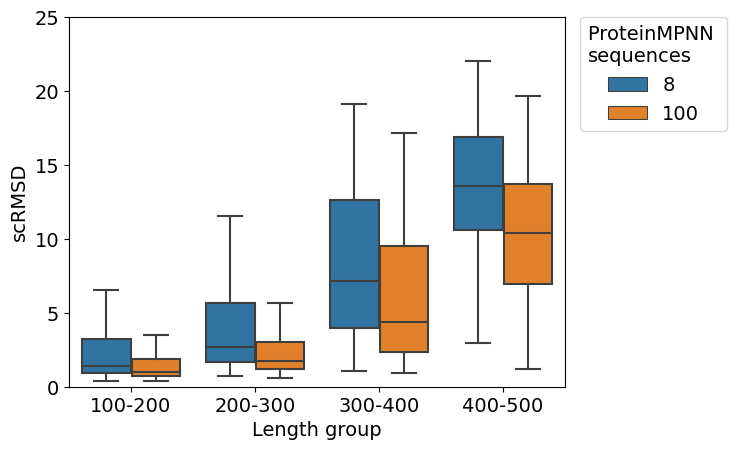

In [29]:
plot_sc_rmsd(self_conditioned_df, save_path='scrmsd_plot.png')

Percent designable: 0.8777777777777778
Average scRMSD: 5.605950988103823
Percent designable: 0.7358024691358025
Average scRMSD: 7.555791918342231


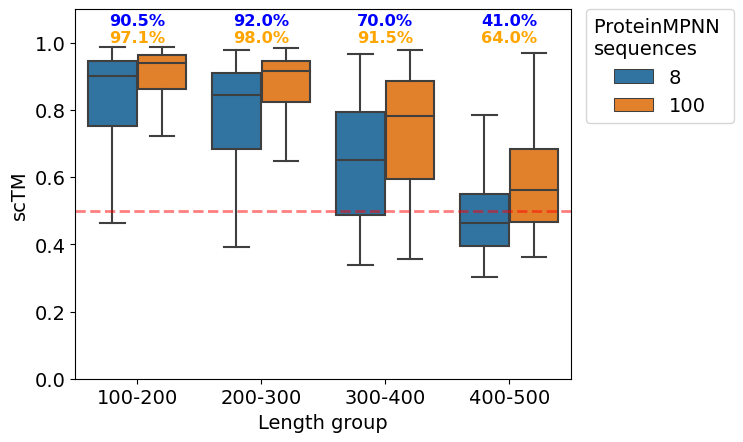

In [30]:
plot_sc_tm(self_conditioned_df, save_path='sctm_plot.png')

Percent designable: 0.3950617283950617
Average scRMSD: 5.121687426797226
Percent designable: 0.2802469135802469
Average scRMSD: 7.100770718482301


/tmp/ipykernel_2407452/249253011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


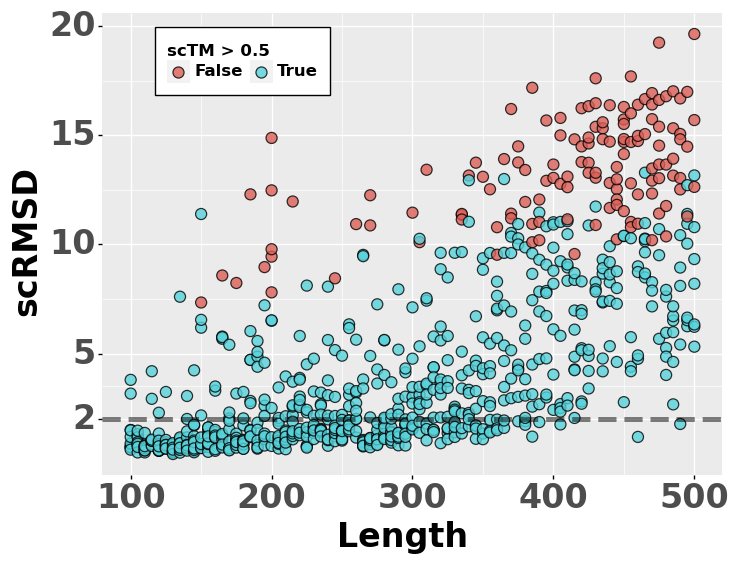

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: designability.png


In [62]:
tm_samples, _ = process_pipeline(self_conditioned_df, metric='rmsd')
tm_100_seq_samples = tm_samples[tm_samples.Sequences == 100]
tm_100_seq_samples['scTM > 0.5'] = tm_100_seq_samples.tm_score > 0.5
# Plot
p = (
    gg.ggplot(
        tm_100_seq_samples,
        gg.aes('length', 'rmsd', fill='scTM > 0.5')
    )
    + gg.geom_point(
        size=4.0,
        alpha=0.8,
        color='black',
    )
    + gg.themes.theme(
        text=gg.element_text(size = 24, face='bold'),
        figure_size=(8, 6),
        legend_text = gg.element_text(size = 12),
        legend_title = gg.element_text(size = 12),
        # legend_position=(.35, 0.25),
        legend_direction='horizontal',
        legend_box_margin=4,
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        legend_position=(.3, 0.8),
    )
    + gg.labels.ylab('scRMSD')
    + gg.labels.xlab('Length')
    + gg.geom_hline(
        color='black',
        size=2,
        linetype="dashed",
        yintercept=2.0,
        alpha=0.5
    )
    + gg.scales.scale_y_continuous(
        breaks=[2.0, 5.0, 10.0, 15.0, 20.0],
    )
    # + gg.geom_text('2', x=0.0, y=0.0, label='small')
)

print(p)
p.save(filename='designability.png', dpi=300, bbox_inches="tight")

In [ ]:
# Plot
p = (
    gg.ggplot(
        results_df,
        gg.aes('rmsd', 'top_hit_score', fill='length')
    )
    + gg.geom_point(
        size=4.0,
        alpha=0.8,
        color='black',
    )
    # + gg.geom_point(colour = "black")
    + gg.labels.xlab('scRMSD')
    + gg.labels.ylab('pdbTM')
    + gg.labels.labs(fill='Length')
    + gg.scale_fill_gradient2(low = "blue", mid='cyan', high = "red", midpoint=300)
    # + gg.scales.ylim(0.0, 1.0)
    # + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        text=gg.element_text(size = 24, face='bold'),
        figure_size=(6, 6),
        legend_text = gg.element_text(size = 12),
        legend_title = gg.element_text(size = 12),
        # legend_position=(.35, 0.25),
        legend_direction='horizontal',
        legend_box_margin=4,
        legend_background=gg.themes.element_rect(fill='white', color='black'),
    )
    # + gg.scale_color_discrete(l=.3)
)

print(p)
p.save(filename='pdbtm_scrmsd.png', dpi=300, bbox_inches="tight")

# Write out samples

In [8]:
def calc_plddt(df):
    all_plddt = {}
    for i,path in enumerate(df.esmf_path):
        sample_feats = du.parse_pdb_feats('sample', path)
        all_plddt[path] = sample_feats['b_factors'][:, 1]
        if i % 100 == 0:
            print(i)
    df['pLDDT'] = df.esmf_path.apply(lambda x: np.mean(all_plddt[x]))
    return df

def filter_samples(df, rmsd_cutoff=5):
    return df[df.rmsd < rmsd_cutoff]

In [9]:
tm_samples, _ = process_pipeline(self_conditioned_df, metric='rmsd')
tm_100_seq_samples = tm_samples[tm_samples.Sequences == 100]

Percent designable: 0.8671679197994987
Average scRMSD: 4.859748893995657
Percent designable: 0.8057644110275689
Average scRMSD: 5.932000642841216


NameError: name 'v' is not defined

In [10]:
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_alt_results'
backbones_dir = os.path.join(base_dir, 'high_quality_samples')
esmf_dir = os.path.join(base_dir, 'high_quality_samples_esmf')

# shutil.rmtree(backbones_dir)
# shutil.rmtree(esmf_dir)
os.makedirs(backbones_dir, exist_ok=True)
os.makedirs(esmf_dir, exist_ok=True)

for i, row in tm_100_seq_samples.iterrows():
    bb_path = os.path.join(backbones_dir, f'length_{row.length}_id_{row.sample_id}.pdb')
    shutil.copy(row.backbone_path, bb_path)
    
    esmf_path = os.path.join(esmf_dir, f'length_{row.length}_id_{row.sample_id}_seq_{row.sequence_id}.pdb')
    shutil.copy(row.esmf_path, esmf_path)

In [11]:
print(backbones_dir)
print(esmf_dir)

/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_alt_results/high_quality_samples
/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_alt_results/high_quality_samples_esmf


# Look at foldseek alignments

In [12]:
all_ss_metrics = [
    'non_coil_percent',
    'coil_percent',
    'helix_percent',
    'strand_percent',
    'radius_of_gyration'
]
def calc_metrics(df):
    all_plddt = {}
    all_ss = {}
    print('calculating esmf metrics')
    for i,path in enumerate(df.esmf_path):
        sample_feats = du.parse_pdb_feats('sample', path)
        all_plddt[path] = sample_feats['b_factors'][:, 1]
        all_ss[path] = calc_ss(path)
        if i % 100 == 0:
            print(i)
    print('calculating backbone metrics')
    for i,path in enumerate(df.backbone_path):
        all_ss[path] = calc_ss(path)
        if i % 100 == 0:
            print(i)
    df['pLDDT'] = df.esmf_path.apply(lambda x: np.mean(all_plddt[x]))
    for x in all_ss_metrics:
        df[x] = df.esmf_path.apply(lambda y: all_ss[y][x])
    return df

def calc_ss(path):
    traj = md.load(path)
    pdb_ss = md.compute_dssp(traj, simplified=True)
    pdb_coil_percent = np.mean(pdb_ss == 'C')
    pdb_helix_percent = np.mean(pdb_ss == 'H')
    pdb_strand_percent = np.mean(pdb_ss == 'E')
    pdb_ss_percent = pdb_helix_percent + pdb_strand_percent 
    pdb_rg = md.compute_rg(traj)[0]
    return {
        'non_coil_percent': pdb_ss_percent,
        'coil_percent': pdb_coil_percent,
        'helix_percent': pdb_helix_percent,
        'strand_percent': pdb_strand_percent,
        'radius_of_gyration': pdb_rg,
    }

def filter_samples(df, rmsd_cutoff=5):
    return df[df.rmsd < rmsd_cutoff]


In [13]:
samples_df = calc_metrics(tm_100_seq_samples)


calculating esmf metrics
0
100
200
300
400
500
600
700
calculating backbone metrics
0
100
200
300
400
500
600
700


/tmp/ipykernel_2407452/1692188924.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2407452/1692188924.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_2407452/1692188924.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykerne

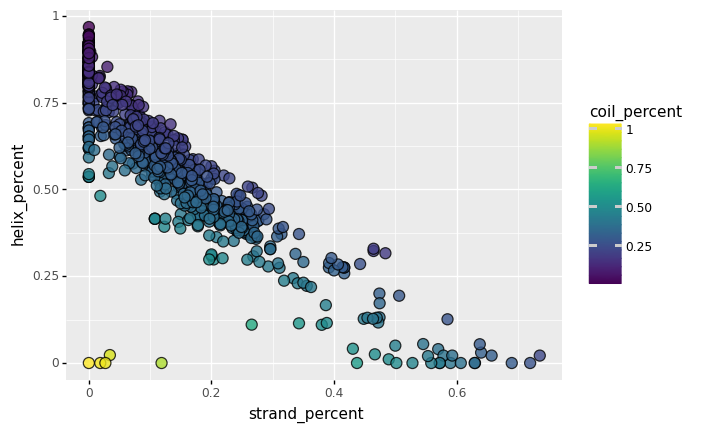

In [14]:
# Plot
p = (
    gg.ggplot(
        samples_df,
        gg.aes('strand_percent', 'helix_percent', fill='coil_percent')
    )
    + gg.geom_point(
        size=4.0,
        alpha=0.8,
        color='black',
    )
    # + gg.geom_point(colour = "black")
    # + gg.labels.xlab('scRMSD')
    # + gg.labels.ylab('pdbTM')
    # + gg.labels.labs(fill='Length')
    # + gg.scale_fill_gradient2(low = "blue", mid='cyan', high = "red", midpoint=300)
    # + gg.themes.theme(
    #     text=gg.element_text(size = 24, face='bold'),
    #     figure_size=(6, 6),
    #     legend_text = gg.element_text(size = 12),
    #     legend_title = gg.element_text(size = 12),
    #     # legend_position=(.35, 0.25),
    #     legend_direction='horizontal',
    #     legend_box_margin=4,
    #     legend_background=gg.themes.element_rect(fill='white', color='black'),
    # )
    # + gg.scale_color_discrete(l=.3)
)

print(p)
# p.save(filename='pdbtm_scrmsd.png', dpi=300, bbox_inches="tight")

In [16]:
aln_path = '/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_alt_results/aln_noise_01_seqs_100_esmf.m8'
alignments_df = {
    'length': [],
    'sample_id': [],
    'top_hit': [],
    'top_hit_score': [],
    'raw': []
}

for line in open(aln_path, 'r').readlines():
    sample, top_hit, top_score = line.split()[:3]
    sample = sample.replace('.pdb', '')
    length = int(sample.split('_')[1])
    sample_id = int(sample.split('_')[3])
    top_score = float('{:f}'.format(float(top_score)))
    alignments_df['length'].append(length)
    alignments_df['sample_id'].append(sample_id)
    alignments_df['top_hit'].append(top_hit)
    alignments_df['top_hit_score'].append(top_score)
    alignments_df['raw'].append(line)
alignments_df = pd.DataFrame(alignments_df)
hits_df = alignments_df.sort_values('top_hit_score', ascending=False)
hits_df = hits_df.groupby(['length', 'sample_id']).first().reset_index()

In [17]:
results_df = samples_df.merge(hits_df, on=['length', 'sample_id'])
results_df = results_df[results_df.rmsd < 5]
print(results_df.shape[0])

512


In [ ]:
results_df[(results_df.rmsd < 2.5) & (results_df.top_hit_score < 0.6)].sort_values('pLDDT', ascending=True)

In [19]:
filtered_df = samples_df[samples_df.rmsd < 5]
# filtered_df = samples_df
print(filtered_df.shape[0])

514


In [20]:
results_df = filtered_df.merge(hits_df, on=['length', 'sample_id'])
print(results_df.shape[0])

512


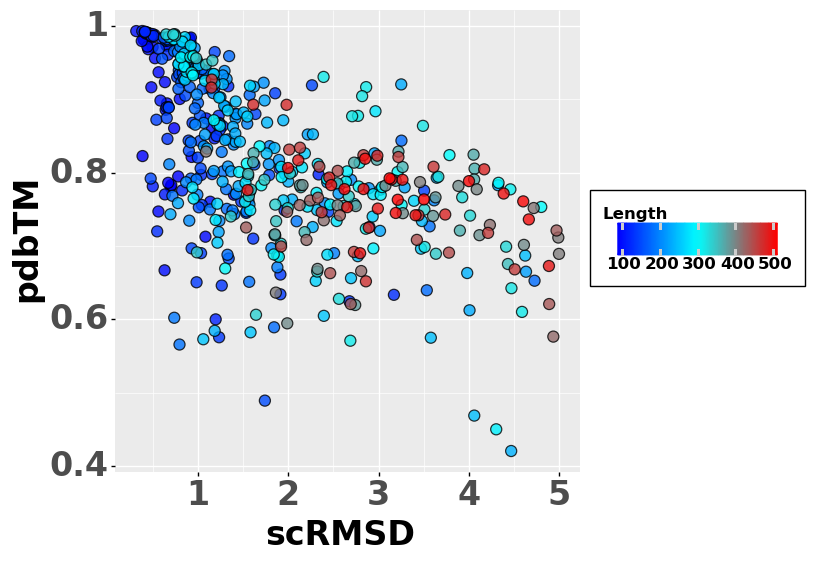

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: pdbtm_scrmsd.png


In [21]:
# Plot
p = (
    gg.ggplot(
        results_df,
        gg.aes('rmsd', 'top_hit_score', fill='length')
    )
    + gg.geom_point(
        size=4.0,
        alpha=0.8,
        color='black',
    )
    # + gg.geom_point(colour = "black")
    + gg.labels.xlab('scRMSD')
    + gg.labels.ylab('pdbTM')
    + gg.labels.labs(fill='Length')
    + gg.scale_fill_gradient2(low = "blue", mid='cyan', high = "red", midpoint=300)
    # + gg.scales.ylim(0.0, 1.0)
    # + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        text=gg.element_text(size = 24, face='bold'),
        figure_size=(6, 6),
        legend_text = gg.element_text(size = 12),
        legend_title = gg.element_text(size = 12),
        # legend_position=(.35, 0.25),
        legend_direction='horizontal',
        legend_box_margin=4,
        legend_background=gg.themes.element_rect(fill='white', color='black'),
    )
    # + gg.scale_color_discrete(l=.3)
)

print(p)
p.save(filename='pdbtm_scrmsd.png', dpi=300, bbox_inches="tight")

In [ ]:
results_df.head()

In [25]:
results_df[(results_df.rmsd < 2) & (results_df.top_hit_score < 0.6)].sort_values('length', ascending=False)

,length,sample_id,tm_score,header,sequence,rmsd,sequence_id,esmf_path,backbone_path,length_group,...,Sequences,pLDDT,non_coil_percent,coil_percent,helix_percent,strand_percent,radius_of_gyration,top_hit,top_hit_score,raw
438,390,5,0.913232,"T=0.1, sample=3, score=0.9173, global_score=0.9173, seq_recovery=0.3128",PWPPATADLPGVCRFFALWGGLVAHLRARGLHAHLAAARAEIAAMAAELLAKMAADPNFDLAAAIDAMVARAVALGAPLAAACREYVAAQGLAARFDAVAARLAALADELMAEGRAWLASLTTPEEKRFAAGAAAVAADGFIRAAGPAGRWIRWAAENFPAADYGELALNGARFAMGLVLRLGAATGLGAALALLLDLLLEGLLAEAAALGAGSVVIGDGAADLALALENPEGLRARVAFAIAHGETLRTPEGGRALLAHTRALLAADPRRPPAVYYVDTSLARAPDDVLTPEGRAIMAAAMEALAADPAVHAVGLIIANRPEVAALAREGAEAAGFPRVDVLVDLRSPTPEGAEAGLAAAEASAAAAAYRCATHAAADAARLAAAARPA,1.988872,3,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_390/sample_5/mpnn/esmf/sample_3.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_390/sample_5/sde_1.pdb,300-400,...,100,66.593077,0.797436,0.202564,0.748718,0.048718,2.035431,5chy_A,0.5945,length_390_id_5_seq_3.pdb\t5chy_A\t5.945E-01\t3.278E-01\n
286,255,3,0.960155,"T=0.1, sample=60, score=0.9015, global_score=0.9015, seq_recovery=0.3294",MEPTPEERAAYAKATSRVTITLTADGIARVELSPNANVIGTLLAIAATLIAGAATGRAAEAGAAAGRAFFGAALEWRLAAGGSGVARVAAADRAALAAAVAARDLAGVAAGLDALLAAQAAGLTLPPEEKAAAAAALAAELEALRAAAREAIARAAELASRAAETLSGAAAAAALTAGVDWAIGCFELLTSHATAGFKVTVGVLIEVDPDGTVTLTVGVNIEPVPSVEEGRASAAEGAARLRAGVARFAAAVAAL,1.058193,60,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_255/sample_3/mpnn/esmf/sample_60.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_255/sample_3/sde_1.pdb,200-300,...,100,76.921686,0.796078,0.203922,0.643137,0.152941,1.812280,2bky_Y,0.5728,length_255_id_3_seq_60.pdb\t2bky_Y\t5.728E-01\t2.656E-01\n
289,255,9,0.923631,"T=0.1, sample=3, score=0.8825, global_score=0.8825, seq_recovery=0.4118",AEAAVAELRALAAAAGFSPADAGLILAALAVRSLLELAATAGPAGVAAAGARLLAVVAASALYAGHTFAAATGAQLLAFLAAAARAALLGAAARDALLAALLAAGASPADIAAARAAAEAFRAAYLTPADAATLDATGDGAAAAASPDAAARAALAAQRTLADLLERGATLDPEAQLAACVEAARGCGALGRLGEAAALLALTRGDADAAGVEALLAIGAAQGVDPERARALADGLLAMRATADAATAAFLAAHA,1.582010,3,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_255/sample_9/mpnn/esmf/sample_3.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_255/sample_9/sde_1.pdb,200-300,...,100,79.157529,0.803922,0.196078,0.803922,0.000000,1.720753,3rmi_A,0.5822,length_255_id_9_seq_3.pdb\t3rmi_A\t5.822E-01\t4.005E-01\n
259,240,0,0.949078,"T=0.1, sample=5, score=1.0020, global_score=1.0020, seq_recovery=0.2208",SVEVPEEDRALLRAAIDAGFAHARAARAALATEHGTAPAAPVTETHTVVDEATGTTVTIGRATLSPGSTHSVTVTSPVGDWDVLGLVITRTSIRVVGYVGRYDPATGVTTLTGDALTTRLEGYTPEQLARRLACIAALMPEIMARVHAFADADPAVVGIVVVSCSPAVAEAAAAAGAANTRVTTVAIGVVTEPDATTVTLDGTETRTVTTPEGARAALAEALGRALAAVARGARARAAAA,1.184366,5,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_240/sample_0/mpnn/esmf/sample_5.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/continue_0/05D_01M_2023Y_21h_15m_16s/unconditional/noise_level_01/length_240/sample_0/sde_1.pdb,200-300,...,100,72.176042,0.708333,0.291667,0.391667,0.316667,1.734131,4v48_BK,0.5843,length_240_id_0_seq_5.pdb\t4v48_BK\t5.843E-01\t3.755E-01\n
177,190,6,0.970105,"T=0.1, sample=1, score=0.9666, global_score=0.9666, seq_recovery=0.3211",AEERLARFCKLLAEMAKLPPAEAKALADAAAAEDPWVGTLLAALTAVMLAAGRLARLKEITPEDVAAERARVRAWVAGAAAGDAAALAAARADARAAGFTLPDDASGLELFEEAAEKMVGGDLEPVRAIGVEILRELLAEIGVPEEAAARLAAMFAAILDAIAEATKKWAEDKAEARAAIREGLVAAAAA,0.794684,1,/data/rsg/chemistry/jyim/projects/protein_diff

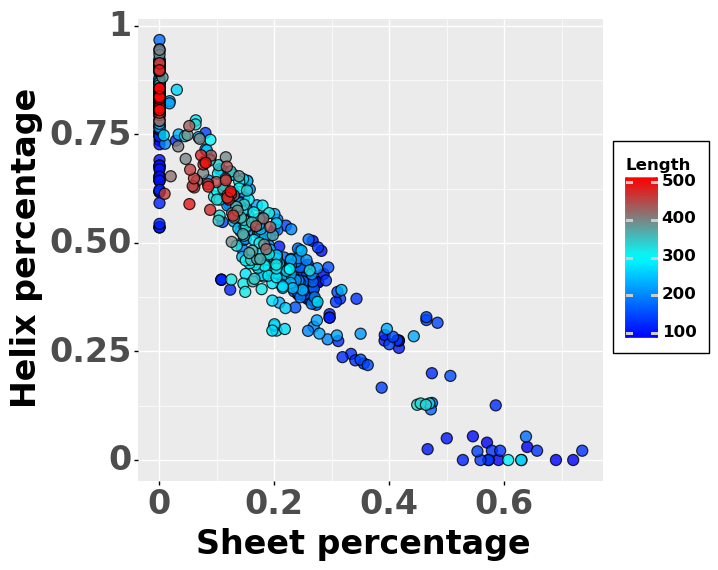

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: secondary_structure.png


In [70]:
# Plot
p = (
    gg.ggplot(
        results_df,
        gg.aes('strand_percent', 'helix_percent', fill='length')
    )
    + gg.geom_point(
        size=4.0,
        alpha=0.8,
        color='black',
    )
    + gg.labels.xlab('Sheet percentage')
    + gg.labels.ylab('Helix percentage')
    + gg.labels.labs(fill='Length')
    + gg.scale_fill_gradient2(low = "blue", mid='cyan', high = "red", midpoint=300)
    + gg.themes.theme(
        text=gg.element_text(size = 24, face='bold'),
        figure_size=(6, 6),
        legend_text = gg.element_text(size = 12, face=None),
        legend_title = gg.element_text(size = 12),
        # legend_position=(.7, 0.7),
        # legend_direction='horizontal',
        legend_box_margin=4,
        legend_background=gg.themes.element_rect(fill='white', color='black'),
    )
    # + gg.scale_color_discrete(l=.3)
)

print(p)
p.save(filename='secondary_structure.png', dpi=300, bbox_inches="tight")

In [319]:
results_df.head()

,length,sample_id,tm_score,header,sequence,rmsd,sequence_id,esmf_path,backbone_path,length_group,...,Sequences,pLDDT,non_coil_percent,coil_percent,helix_percent,strand_percent,radius_of_gyration,top_hit,top_hit_score,raw
0,100,0,0.847955,"T=0.1, sample=85, score=0.8878, global_score=0.8878, seq_recovery=0.4500",ALAPEALAAARLAAIAGGLTPEDLAALAARMRAELGEGSARLAIARAAGAEAIAKAEAALGNAAAAAARRAAARAAGAAAAAAGGETVTEEERLAAIADL,1.507540,85,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_0/mpnn/esmf/sample_85.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_0/sde_1.pdb,100-200,...,100,78.3390,0.76,0.24,0.76,0.00,1.286950,7aoi_UF,0.5386,length_100_id_0_seq_85.pdb\t7aoi_UF\t5.386E-01\t4.853E-01\n
1,100,1,0.955103,"T=0.1, sample=2, score=1.0143, global_score=1.0143, seq_recovery=0.1000",SGEELKELAEKVIAEANMDVPVKVVVGAPGTLTEEDIKKAAEENGNGVTIVMITNDEDPDKPGEMKEKKEGDRTTITIGVNSNDKEDAIAAIKKAIEKIK,0.694133,2,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_1/mpnn/esmf/sample_2.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_1/sde_1.pdb,100-200,...,100,81.3223,0.70,0.30,0.41,0.29,1.290228,6ut6_G,0.7237,length_100_id_1_seq_2.pdb\t6ut6_G\t7.237E-01\t5.538E-01\n
2,100,2,0.952632,"T=0.1, sample=27, score=0.9305, global_score=0.9305, seq_recovery=0.2900",SAALECARAAVKEVQAFPCTAKKVDPAKFPGAAAKVPEQVGGEEILARLDAGEVTFEEVKALGAQLAAQVAALNPSPDTPCRKDGAAAAAAWEAGAAACE,0.760142,27,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_2/mpnn/esmf/sample_27.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_2/sde_1.pdb,100-200,...,100,82.1943,0.69,0.31,0.69,0.00,1.314443,5s8q_B,0.9108,length_100_id_2_seq_27.pdb\t5s8q_B\t9.108E-01\t7.533E-01\n
3,100,3,0.645119,"T=0.1, sample=41, score=1.0625, global_score=1.0625, seq_recovery=0.1600",AVTTTTAFYTGPDGKTYKVTSVTAGPALQAAGAALGYLLVGLPPTPTHPAGLAAFKEAAASGKQDVTLTVTVPGLGGPGEPSGTTPAVTAVSVLTVSKVD,3.799311,41,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_3/mpnn/esmf/sample_41.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_3/sde_1.pdb,100-200,...,100,42.7169,0.55,0.45,0.23,0.32,1.423848,2kpz_A,0.6407,length_100_id_3_seq_41.pdb\t2kpz_A\t6.407E-01\t4.349E-01\n
4,100,4,0.724135,"T=0.1, sample=3, score=1.1507, global_score=1.1507, seq_recovery=0.1400",PPVKPGSTTEIKIEEECDEDTGCTSVSVSTSSEGTSVTVTTRTKDAANITFTGDAETQAAIQAKANAGFAEAAATASWVKVTATGGTGGKSVTVEGWSDE,3.171567,3,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_4/mpnn/esmf/sample_3.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_100/sample_4/sde_1.pdb,100-200,...,100,53.6445,0.60,0.40,0.22,0.38,1.409965,2zgi_C,0.6006,length_100_id_4_seq_3.pdb\t2zgi_C\t6.006E-01\t5.376E-01\n


In [318]:
cols = [
    'esmf_path',
    'backbone_path',
    'top_hit',
    'rmsd',
    'length',
    'top_hit_score',
    'pLDDT',
    'strand_percent',
    'helix_percent'
]
results_df.sort_values('top_hit_score', ascending=True)[cols].head(10)
results_df[(results_df.top_hit_score > 0.5) & (results_df.top_hit_score < 0.6) & (results_df.length > 370)][cols]

,esmf_path,backbone_path,top_hit,rmsd,length,top_hit_score,pLDDT,strand_percent,helix_percent
459,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_385/sample_1/mpnn/esmf/sample_33.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_385/sample_1/sde_1.pdb,5cwg_A,4.501904,385,0.5785,56.945429,0.0,0.914286
488,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_450/sample_0/mpnn/esmf/sample_86.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_450/sample_0/sde_1.pdb,6ob6_A,2.777827,450,0.5163,62.996711,0.0,0.908889
492,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_460/sample_3/mpnn/esmf/sample_23.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_460/sample_3/sde_1.pdb,4av6_A,1.186333,460,0.5333,75.311065,0.0,0.921739
495,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_480/sample_9/mpnn/esmf/sample_71.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_480/sample_9/sde_1.pdb,2zop_E,4.863874,480,0.5530,58.164083,0.0,0.825000
497,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_485/sample_8/mpnn/esmf/sample_24.pdb,/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100/length_485/sample_8/sde_1.pdb,6o7t_c,4.620891,485,0.5430,62.790660,0.0,0.901031


Percent designable: 0.8508474576271187
Average scRMSD: 4.7607433707952405
Percent designable: 0.7118012422360248
Average scRMSD: 7.098213523715471


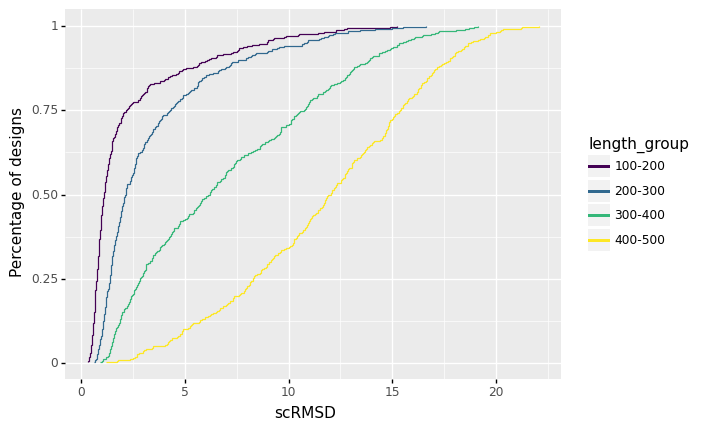

In [24]:
# Plot
rmsd_samples, _ = process_pipeline(self_conditioned_df, metric='rmsd')
p = (
    gg.ggplot(
        rmsd_samples,
        gg.aes('rmsd', color='length_group')
    )
    + gg.stats.stat_ecdf()
    # + gg.scales.scale_x_reverse()
    # + gg.geoms.geom_vline(
    #     xintercept=cutoff,
    #     size=1.0,
    #     linetype='dashed',
    #     color='red',
    # )
    + gg.labels.xlab('scRMSD')
    + gg.labels.ylab('Percentage of designs')
)

print(p)

# Save samples

In [47]:
sample_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_seqs_100'
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_seqs_100_results'
# os.makedirs(base_dir, exist_ok=True)
designed_samples_dir = os.path.join(base_dir, 'designed_samples')
designed_samples_cluster_dir = os.path.join(base_dir, 'designed_samples_clustering')

shutil.rmtree(designed_samples_dir)
shutil.rmtree(designed_samples_cluster_dir)

os.makedirs(designed_samples_dir, exist_ok=False)
os.makedirs(designed_samples_cluster_dir, exist_ok=False)
fname = os.path.join(designed_samples_dir, 'sc_pdbs.txt')

with open(fname, 'w') as f:
    for sample_length in os.listdir(sample_dir):
        if '.' in sample_length:
            continue
        length_dir = os.path.join(sample_dir, sample_length)
        length = sample_length.split('_')[1]
        for sample_name in os.listdir(length_dir):
            if '.' in sample_name:
                continue
            sample_path = os.path.join(length_dir, sample_name, 'sde_1.pdb')
            sample_id = sample_name.split('_')[1]
            save_path = os.path.join(designed_samples_dir, f'length_{length}_id_{sample_id}.pdb')
            shutil.copy(sample_path, save_path)
            f.write(save_path+'\n')
print(
    f'./maxcluster64bit -l {fname} -C 2 -in -Rl {designed_samples_cluster_dir}/all_by_all_lite \-TM -Tm 0.5 > {designed_samples_cluster_dir}/maxcluster_results.txt'
)

./maxcluster64bit -l /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_seqs_100_results/designed_samples/sc_pdbs.txt -C 2 -in -Rl /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_seqs_100_results/designed_samples_clustering/all_by_all_lite \-TM -Tm 0.5 > /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_seqs_100_results/designed_samples_clustering/maxcluster_results.txt


In [49]:
sample_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_steps_100'
base_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_steps_100_results'
# os.makedirs(base_dir, exist_ok=True)
designed_samples_dir = os.path.join(base_dir, 'designed_samples')
designed_samples_cluster_dir = os.path.join(base_dir, 'designed_samples_clustering')

# shutil.rmtree(designed_samples_dir)
# shutil.rmtree(designed_samples_cluster_dir)

os.makedirs(designed_samples_dir, exist_ok=False)
os.makedirs(designed_samples_cluster_dir, exist_ok=False)
fname = os.path.join(designed_samples_dir, 'sc_pdbs.txt')

with open(fname, 'w') as f:
    for sample_length in os.listdir(sample_dir):
        if '.' in sample_length:
            continue
        length_dir = os.path.join(sample_dir, sample_length)
        length = sample_length.split('_')[1]
        for sample_name in os.listdir(length_dir):
            if '.' in sample_name:
                continue
            sample_path = os.path.join(length_dir, sample_name, 'sde_1.pdb')
            sample_id = sample_name.split('_')[1]
            save_path = os.path.join(designed_samples_dir, f'length_{length}_id_{sample_id}.pdb')
            shutil.copy(sample_path, save_path)
            f.write(save_path+'\n')
print(
    f'./maxcluster64bit -l {fname} -C 2 -in -Rl {designed_samples_cluster_dir}/all_by_all_lite \-TM -Tm 0.5 > {designed_samples_cluster_dir}/maxcluster_results.txt'
)

./maxcluster64bit -l /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_steps_100_results/designed_samples/sc_pdbs.txt -C 2 -in -Rl /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_steps_100_results/designed_samples_clustering/all_by_all_lite \-TM -Tm 0.5 > /data/rsg/chemistry/jyim/paper/protdiff_icml/noise_level_01_steps_100_results/designed_samples_clustering/maxcluster_results.txt


# Compare with RFdiffusion

In [25]:
all_csvs = []
results_dir = '/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_rf_benchmark'
print(f'Reading samples from {results_dir}')
for sample_length in os.listdir(results_dir):
    if '.' in sample_length:
        continue
    length_dir = os.path.join(results_dir, sample_length)
    for i,sample_name in enumerate(os.listdir(length_dir)):
        if '.' in sample_name:
            continue
        csv_path = os.path.join(length_dir, sample_name, 'mpnn', 'sc_results.csv')
        if os.path.exists(csv_path):
            design_csv = pd.read_csv(csv_path, index_col=0)
            design_csv['length'] = int(sample_length.split('_')[1])
            design_csv['sample_id'] = i
            all_csvs.append(design_csv)
benchmark_df = pd.concat(all_csvs)


Reading samples from /data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/noise_level_01_rf_benchmark


In [26]:
# Format RF diffusion samples
s2f_df = pd.read_csv('S2F_data.csv')
s2f_df['Unconditional'] = s2f_df.problem.apply(lambda x: 'uncond' in x)
rfdiff_samples_df = s2f_df[s2f_df['Unconditional']]
metric = 'rmsd_af2_des'
df_temp = rfdiff_samples_df.sort_values(metric)
df_temp = df_temp.drop_duplicates('name')

cols = [
    'rmsd_af2_des',
    'problem',
    'random',
]
formatted_rf_diff = {
    'length': rfdiff_samples_df.problem.apply(lambda x: int(x.split('_')[1])),
    'rmsd': rfdiff_samples_df.rmsd_af2_des,
    'model': rfdiff_samples_df.random.map({
        'Outputs without Pre-Training': 'RFDiffusion \nw/o pretraining',
        'Outputs with Pre-Training': 'RFDiffusion',
    }),
}
formatted_rf_diff = pd.DataFrame(formatted_rf_diff)


/tmp/ipykernel_2038229/3899596801.py:2: DtypeWarning: Columns (98,118,119,121,122,127,133,134,135,139,140) have mixed types. Specify dtype option on import or set low_memory=False.


In [30]:
# Format FrameDiff samples
# rmsd_samples, _ = process_pipeline(refolded_df, metric='rmsd')
rmsd_samples, _ = process_pipeline(benchmark_df, metric='rmsd', length_cutoff=False)
rmsd_seq_8_samples = rmsd_samples[rmsd_samples.Sequences == 8]
formatted_framediff = rmsd_seq_8_samples[['length', 'rmsd']]
formatted_framediff = formatted_framediff[formatted_framediff.length.isin([70, 100, 200, 300])]
formatted_framediff['model'] = 'FrameDiff'

Percent designable: 0.888030888030888
Average scRMSD: 3.4019272693747276
Percent designable: 0.8823466323466324
Average scRMSD: 3.4912775264944127


In [31]:
formatted_framediff.length.value_counts()

70     2399
100    2399
300    2191
200    1839
Name: length, dtype: int64

In [32]:
formatted_df = pd.concat([formatted_rf_diff, formatted_framediff], axis=0)

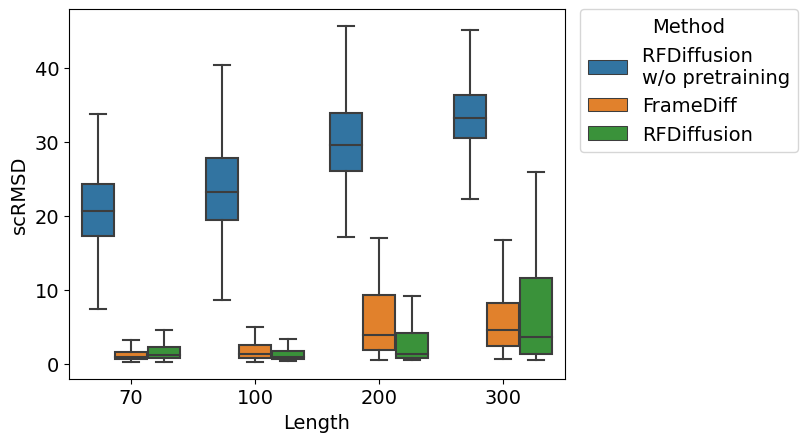

In [33]:
order = ['RFDiffusion \nw/o pretraining', 'FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = formatted_df,
    hue = 'model',
    hue_order=order,
    showfliers = False
)

# plt.ylim(0.0, 1.1)
# plt.show()
plt.xlabel('Length')
plt.ylabel('scRMSD')
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
ax.legend_.set_title('Method')
# plt.show()
plt.savefig('rfdiffusion_benchmark.png', bbox_inches='tight')

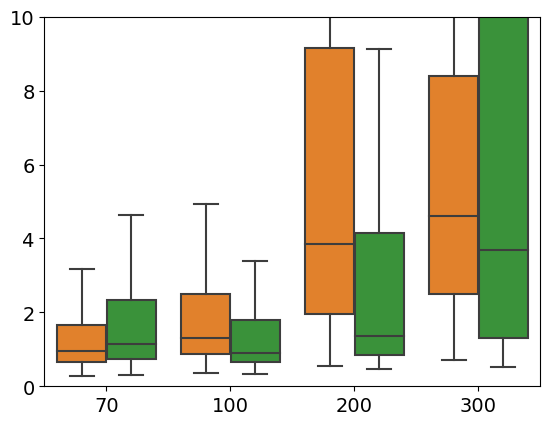

In [33]:
zoomed_df = formatted_df[formatted_df.model.isin(['FrameDiff', 'RFDiffusion'])]
order = ['FrameDiff', 'RFDiffusion']
ax = sns.boxplot(
    x = 'length',
    y = 'rmsd',
    data = zoomed_df,
    hue = 'model',
    hue_order=order,
    showfliers = False,
    palette = ['#ff7f0e', '#2ca02c']
)
ax.set(xlabel=None)
ax.set(ylabel=None)
plt.ylim(0.0, 10)
legend = plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0)
legend.remove()
plt.show()
# plt.savefig('rfdiffusion_benchmark.png')


# Clustering

In [57]:
sample_cluster_dir = '/data/rsg/chemistry/jyim/paper/protdiff_icml/noise_scale_10_results/designed_samples_clustering'
file = os.path.join(sample_cluster_dir, 'all_by_all_lite')
with open(file, 'r') as f:
    text = f.read()
    
    size = re.findall(r'SIZE :(.*\d+)', text)[0]
    size = int(size)
    
    id_to_filename = {}
    D = np.ones((size,size))
    for line in text.splitlines():
        if line[:3] == 'PDB':
            _, id_, filename = line.split()
            id_ = int(id_)
            id_to_filename[id_] = filename
        elif line[:2] == 'MS':
            _, _, idx1, idx2, tm1, tm2, pairs = line.split()
            i, j = int(idx1)-1, int(idx2)-1
            tm1, tm2 = float(tm1), float(tm2)
            tm_mean = (tm1 + tm2) / 2
            D[i, j] = 1 - tm1
            D[j, i] = 1 - tm2
D_mean = (D + D.T) / 2
    


<Figure size 200x200 with 0 Axes>

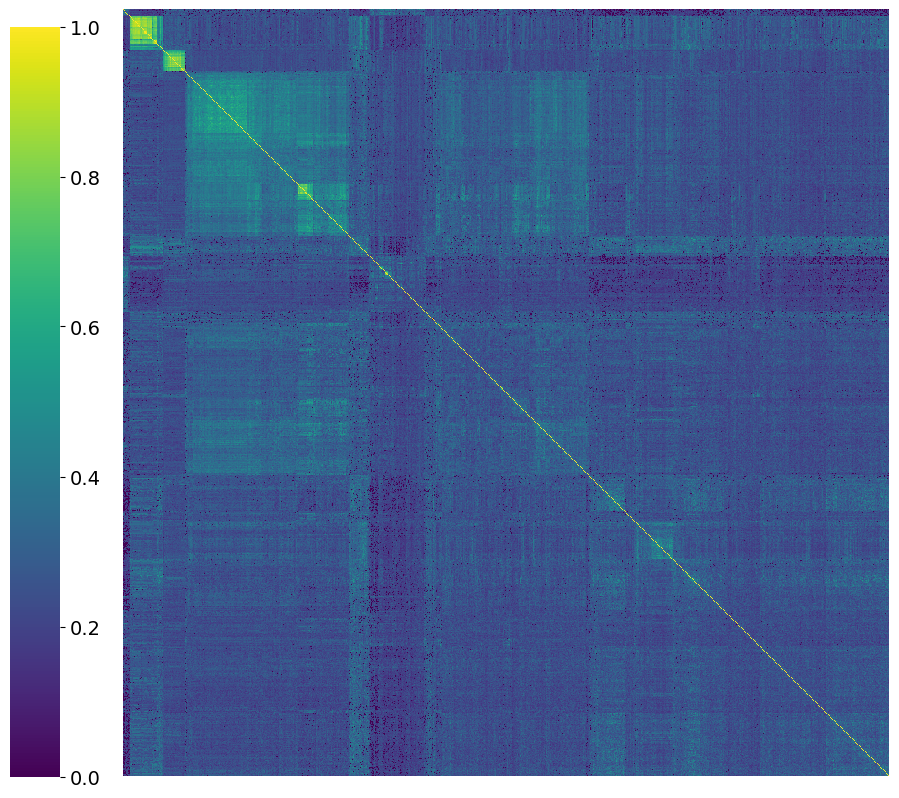

In [58]:
plt.figure(figsize=(2,2))
g = sns.clustermap(
    1 - D_mean,
    method='average',
    figsize=(10,10),
    yticklabels=False,
    xticklabels=False,
    cbar_pos=(0.1, 0.02, 0.05, 0.75),
    cmap='viridis'
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
# plt.show()
plt.savefig('noise_10_clustering.png')

# Align samples to training PDBs

In [63]:
aln_path = '/Mounts/rbg-storage1/users/jyim/aln_exhaustive.m8'

In [64]:
alignments_df = {
    'length': [],
    'sample_id': [],
    'top_hit': [],
    'top_hit_score': [],
    'raw': []
}

for line in open(aln_path, 'r').readlines():
    sample, top_hit, top_score = line.split()[:3]
    sample = sample.replace('.pdb', '')
    length = int(sample.split('_')[1])
    sample_id = int(sample.split('_')[-1])
    top_score = float('{:f}'.format(float(top_score)))
    score = float(score)
    alignments_df['length'].append(length)
    alignments_df['sample_id'].append(sample_id)
    alignments_df['top_hit'].append(top_hit)
    alignments_df['top_hit_score'].append(top_score)
    alignments_df['raw'].append(line)
alignments_df = pd.DataFrame(alignments_df)


In [108]:
hits_df = alignments_df.sort_values('top_hit_score', ascending=False)
hits_df = hits_df.groupby(['length', 'sample_id']).first().reset_index()

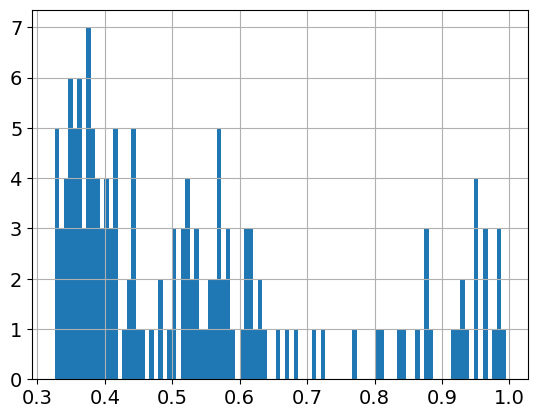

In [109]:
hits_df.top_hit_score.hist(bins=100)
plt.show()

In [47]:
tm_samples, _ = process_pipeline(self_conditioned_df, metric='tm')
tm_8_seq_samples = tm_samples[tm_samples.Sequences == 8]
tm_100_seq_samples = tm_samples[tm_samples.Sequences == 100]

Percent designable: 0.8782608695652174
Average scRMSD: 5.617677709298164
Percent designable: 0.7366459627329193
Average scRMSD: 7.552426409443394


In [52]:
tm_100_seq_samples.shape

(805, 11)

In [56]:
alignments_df.length.value_counts()

170    2220
135     950
155     256
210     224
275     146
265      94
130      74
125      70
330      24
190      22
235      10
310       8
140       6
240       6
175       6
355       4
290       4
120       4
280       2
230       2
320       2
260       2
100       2
270       2
70        2
160       2
Name: length, dtype: int64

In [55]:
alignments_df.head()

,length,sample_id,top_hit,top_hit_score
0,210,2,5j8m_B,0.9131
1,210,2,5j6m_A,0.9122
2,210,2,6ey9_A,0.9153
3,210,2,5j6l_A,0.9121
4,210,2,6lt8_A,0.9100


In [49]:
aligned_df = tm_100_seq_samples.merge(alignments_df, on=['length', 'sample_id'])

In [50]:
aligned_df.shape

(4142, 13)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 3782 rows containing missing values.


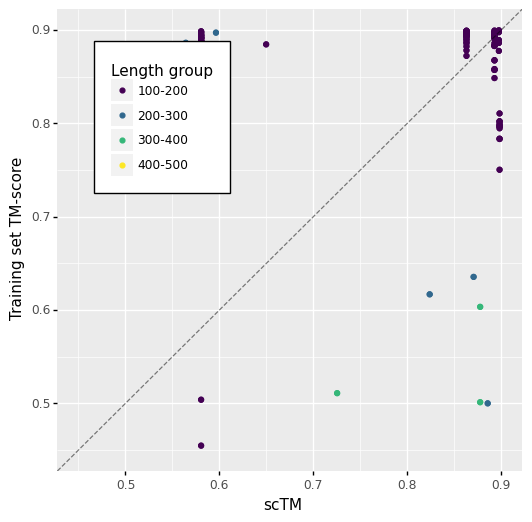

In [23]:
# Plot
p = (
    gg.ggplot(
        aligned_df,
        gg.aes('tm_score', 'top_hit_score', color='length_group')
    )
    + gg.geom_point()
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Training set TM-score')
    + gg.labels.labs(color='Length group')
    + gg.scales.ylim(0.45, 0.90)
    + gg.scales.xlim(0.45, 0.90)
    + gg.themes.theme(
        figure_size=(6, 6),
        legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black')
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
)

print(p)

# Link clusters with PDB similarity

In [100]:
with open('/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_8_seqs/sample_clustering/maxcluster_results.txt', 'r') as f:
    capture = False
    centroid_lines = []
    for line in f.read().splitlines():
        if capture:
            centroid_lines.append(line)
        if 'INFO  : Cluster  Centroid  Size        Spread' in line:
            capture = True
            
centroid_lines = centroid_lines[:-1]

data = {'Cluster size': [], 'path': [], 'length': [], 'sample_id': []} #, 'tm_v_pdb100': []}
for line in centroid_lines:
    line = line.split()
    cluster_size = line[5]
    path = line[7]
    filename = os.path.basename(path).replace('.pdb', '')
    data['Cluster size'].append(int(cluster_size))
    data['path'].append(path)
    data['length'].append(int(filename.split('_')[1]))
    data['sample_id'].append(int(filename.split('_')[3]))

clusters_df = pd.DataFrame(data)

In [101]:
centroid_df = aligned_df.merge(clusters_df, on=['length', 'sample_id'])

In [99]:
designable_8_seq_samples.shape

(461, 11)

In [98]:
401/595

0.6739495798319328

In [103]:
centroid_df.shape

(289, 15)

In [104]:
289 / 461

0.6268980477223427

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



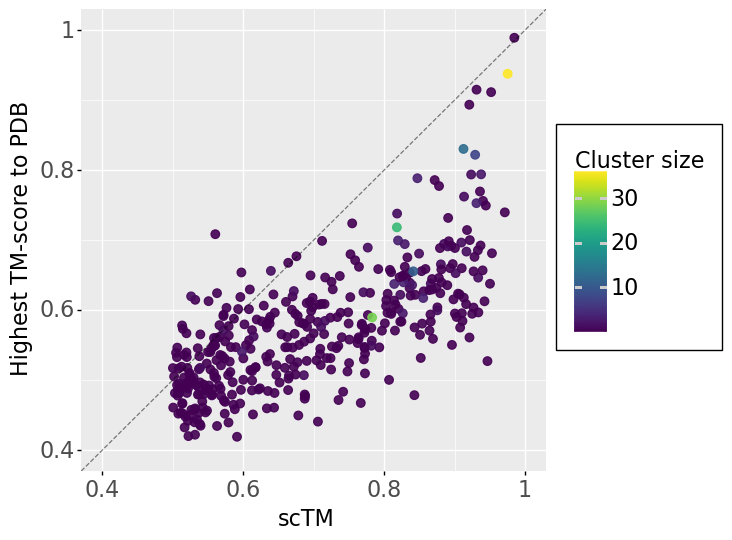

In [15]:
# Plot
p = (
    gg.ggplot(
        centroid_df,
        gg.aes(
            'tm_score',
            'top_hit_score',
            color='Cluster size',
            # marker='Cluster size'
      )
    )
    + gg.geom_point(
        size=3,
        alpha=0.9
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.themes.theme(
        figure_size=(6, 6),
        # legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        text=gg.element_text(size=16)
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
    + gg.scale_y_continuous(breaks = np.linspace(0.2, 1.0, 7))
    + gg.scale_x_continuous(breaks = np.linspace(0.4, 1.0, 7))
    + gg.scales.xlim(0.40, 1.0)
    + gg.scales.ylim(0.40, 1.0)
)

print(p)

In [16]:
# p.save(filename='pdb_align.png', dpi=300)

In [ ]:
sorted_df = centroid_df.sort_values('tm_score', ascending=False)
novel_df = sorted_df[sorted_df.top_hit_score < 0.6]

In [17]:
# novel_df.head()

In [ ]:
/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2/length_240/sample_9/mpnn/esmf/sample_93.pdb

/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2/length_380/sample_9/mpnn/esmf/sample_41.pdb

/data/rsg/chemistry/jyim/projects/protein_diffusion/samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/saved_run_2/length_145/sample_0/mpnn/esmf/sample_85.pdb

In [ ]:
# TODO: Run ESMFold over all these designs to get their pLDDT.

In [23]:
all_sample_sequences = centroid_df.sequence
all_sample_paths = centroid_df.path

In [ ]:
all_sample_sequences.iloc[0]

In [18]:
import esm

In [20]:
torch.hub.set_dir('/data/rsg/chemistry/jyim/.cache/torch')

In [24]:
folding_model = esm.pretrained.esmfold_v1().eval()
folding_model = folding_model.to('cuda')

In [26]:
with torch.no_grad():
    output = folding_model.infer_pdb(all_sample_sequences.iloc[0])

'/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_60_id_0.pdb'

In [36]:
all_plddt = {}
for i,path in enumerate(centroid_df.path):
    sample_feats = du.parse_pdb_feats('sample', path)
    all_plddt[path] = sample_feats['b_factors'][:, 1]
    if i % 100 == 0:
        print(i)

0
100
200
300
400


In [38]:
centroid_df['pLDDT'] = centroid_df.path.apply(lambda x: np.mean(all_plddt[x]))

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



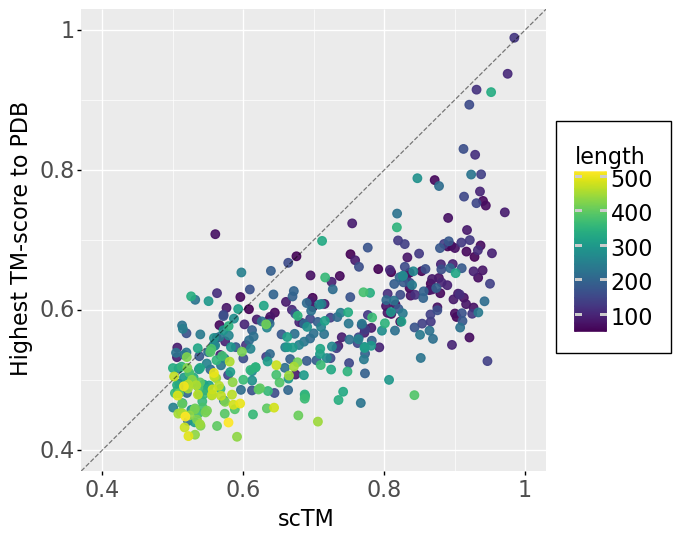

In [78]:
# Plot
p = (
    gg.ggplot(
        centroid_df,
        gg.aes(
            'tm_score',
            'top_hit_score',
            color='length',
            # color='pLDDT',
            # marker='Cluster size'
      )
    )
    + gg.geom_point(
        size=3,
        alpha=0.9
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.themes.theme(
        figure_size=(6, 6),
        # legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        text=gg.element_text(size=16)
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
    + gg.scale_y_continuous(breaks = np.linspace(0.2, 1.0, 7))
    + gg.scale_x_continuous(breaks = np.linspace(0.4, 1.0, 7))
    + gg.scales.xlim(0.40, 1.0)
    + gg.scales.ylim(0.40, 1.0)
)

print(p)

In [79]:
p.save(filename='pdb_align.png', dpi=300)

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6 x 6 in image.
/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: pdb_align.png


In [76]:
sorted_df = centroid_df.sort_values('tm_score', ascending=False)
sorted_df = sorted_df.sort_values('length', ascending=False)
novel_df = sorted_df[(sorted_df.top_hit_score < 0.7) & (sorted_df.pLDDT > 70)]

In [77]:
novel_df.head(20)

,length,sample_id,tm_score,sample_path,header,sequence,rmsd,sequence_id,length_group,designable,Sequences,top_hit,top_hit_score,Cluster size,path,pLDDT
289,320,2,0.901405,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/31D_12M_2022Y_17h_41m_44s/length_320/sample_5/mpnn/esmf/sample_59.pdb,"T=0.1, sample=59, score=1.0484, global_score=1.0484, seq_recovery=0.0906",MEEKREKLEESIESFNSEEVEKKFKEAEENGNYEEWFEYAVELLEKARSPENVGLAVLIFRLMLKSKGEEARRRFLRALVTPEFRELMKHVFALAGDWPNEDIIDFLARVLGDPEIDPDDALAFVLDALEVMKESLPRETLTELFRRIGFENKEPRAAEALARLVEELLAKTKELTPEDRKLLAAAGGGLILGGAGFDPEKGRRWAEWFLSLPLEEENFREALKRAYEEGDSEEAYEFLLEVAEKYDKEFGIELYIEKKAKKEKEKPEIDENFLKEFLELDKKYNINKEKIANIVKEFGKKAKKEEEKEIIKKYLKIYTE,2.072854,59,300-400,True,100,6fvb_A,0.65264,2,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_320_id_2.pdb,74.422156
252,270,6,0.826444,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_270/sample_3/mpnn/esmf/sample_34.pdb,"T=0.1, sample=34, score=0.9703, global_score=0.9703, seq_recovery=0.2148",MECGDWSAEERQALIREAMATDPKKGGVECLKCAKALVEKGRSATALAWYEELMPFLDQMSPELAAEATDAYFELLKDTDVDRAVEVALRGFASGGAAGLVGADKGLAIGLNPDLDPELAERLAEAMWAVAQQPEEGNIGGAIGVALFGLDRPEGRERALEGARLAAADPRHPEFGALWLEVAEAVAFRPDVVGAAAELGERTGNELVEAVGCAFGATLAPERPGAFPALLEAFARCARNPSYGELARRLLARVAAEGGGPAALAARAAP,2.792809,34,200-300,True,100,6sl1_A,0.64880,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_270_id_6.pdb,70.039333
153,185,0,0.910066,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_185/sample_7/mpnn/esmf/sample_9.pdb,"T=0.1, sample=9, score=0.9926, global_score=0.9926, seq_recovery=0.1838",GGAAARAARLEAIIAEFAARAGPAMAEGLRAVLARAAAGASPAEVGAALLEEVGRGEGPAGFEAGVAVGAALGRPEEFAKYLEEHRPFGLLKRALEEKDYEKGIKIAKEALKQYSKGEGEAGLEKLKKLLELLLEMAKEGPLETQKAVEELFKELVKLIEKKLGPEFGKKLLEELKKELEKIKAE,1.471142,9,100-200,True,100,3k8p_D,0.65970,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_185_id_0.pdb,72.719027
150,180,3,0.891645,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_180/sample_0/mpnn/esmf/sample_4.pdb,"T=0.1, sample=4, score=1.0556, global_score=1.0556, seq_recovery=0.2833",SRRRWLAIATLVVFLLELIVAATAALAPLYLRRGPLLGTLVLLLVGAGADLLGEALLGLATGRWAVAAAGAAVTLFSAVGFALGLLLLGLSRRFGDWSPAVRALLAAAAAAAAAAWAATGPLGPDDPGAGLLALAHATAAALLGVAAAAADFGVLCAAEVAAELLYGLAVLLWGLRLARR,2.410424,4,100-200,True,100,7jh5_B,0.69821,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_180_id_3.pdb,73.381778
139,170,0,0.910251,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_170/sample_6/mpnn/esmf/sample_6.pdb,"T=0.1, sample=6, score=1.0163, global_score=1.0163, seq_recovery=0.1176",GSHMEEEGEKIKEEIEKFVESNKDKDPIEIAKEAVEKAIELSKNKTYKGAVLAFAKILELLPESKAIAKELAAKLASSFKGSIGTVRRLLKEAGFDEAIIEAALEAIKNRPGEFFIEALEKSRDLSCEDFFENLELEREYGEKVSGEEILAKIDELRAERRASGCVDPLN,1.437282,6,100-200,True,100,3icq_T,0.59540,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_170_id_0.pdb,83.955529
135,165,5,0.764186,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_165/sample_6/mpnn/esmf/sample_5.pdb,"T=0.1, sample=5, score=1.0916, global_score=1.0916, seq_recovery=0.1879",AALLAALLAALAATIVAGLFGPLWEAGMAAARVVGALLAGGKGLEVIAAAIVAKKGRPEEGYKAVLEAIKGGNTSLAGCRAAFEVAHLFSEEKRKEIKEVLKSKKNGCQPLFDEEAKKEAEELLKGGKSVEEIAKWVKKTGCKECEKWAEKKLKEAKLKELAKLL,2.921147,5,100-200,True,100,7dl2_A,0.66171,1,/data/rsg/chemistry/jyim/paper/protdiff_icml/unconditional_results_100_seqs/samples/length_165_id_5.pdb,73.159394
131,160,7,0.829276,samples/unconditional_512_0/27D_11M_2022Y_09h_58m_16s/unconditional/30D_12M_2022Y_15h_42m_36s/length_160/sample_2/mpnn/esmf/sample_47.pdb,"T=0.1, sample=47, score=0.9262, global_score=0.9262, s

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/data/rsg/chemistry/jyim/miniconda3/envs/dev/lib/python3.8/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



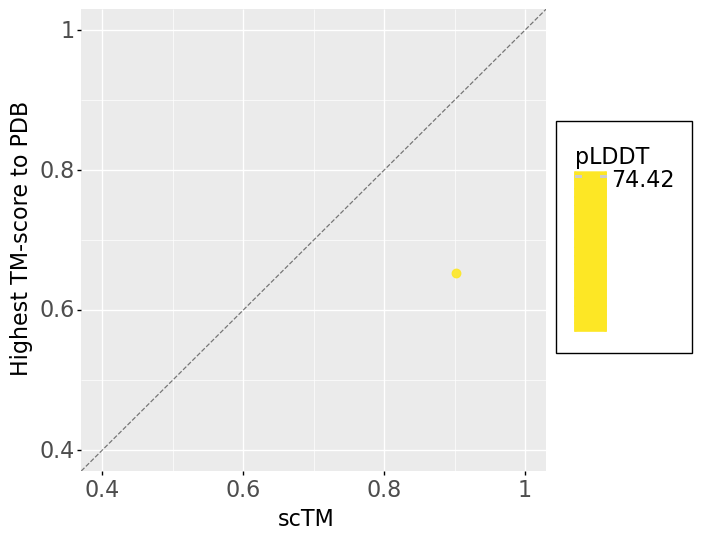

In [71]:
# Plot
p = (
    gg.ggplot(
        novel_df.head(1),
        gg.aes(
            'tm_score',
            'top_hit_score',
            color='pLDDT',
            # marker='Cluster size'
      )
    )
    + gg.geom_point(
        size=3,
        alpha=0.9
    )
    + gg.labels.xlab('scTM')
    + gg.labels.ylab('Highest TM-score to PDB')
    # + gg.labels.labs(color='Length')
    + gg.themes.theme(
        figure_size=(6, 6),
        # legend_position=(0.3, 0.7),
        legend_background=gg.themes.element_rect(fill='white', color='black'),
        text=gg.element_text(size=16)
    )
    + gg.geom_abline(
        gg.aes(intercept=0.0, slope=1.0),
        linetype='dashed',
        alpha=0.5
    )
    + gg.scale_y_continuous(breaks = np.linspace(0.2, 1.0, 7))
    + gg.scale_x_continuous(breaks = np.linspace(0.4, 1.0, 7))
    + gg.scales.xlim(0.40, 1.0)
    + gg.scales.ylim(0.40, 1.0)
)

print(p)